In [1]:
import os
import os.path as osp
import json
import numpy as np

import skimage.io
import matplotlib.pyplot as plt

from utils import transform_coordinates, transform_coordinates_back, adjust_coordinates, crop, crop_pill

In [2]:
path = '../public_data'

In [3]:
label_names = [file for file in os.listdir(path) if file.endswith('.json')]
feature_names = [name.replace('.json', '.tiff') for name in label_names]

In [4]:
idx = 1
img = skimage.io.imread(osp.join(path, feature_names[idx]))

In [5]:
idx=0
_miss_px_all, _pres_px_all = [], []
dics = []
_predictions = {}
predictions = {}
_miss_all, _pres_all = [], []
for idx, val in enumerate(feature_names):
    if idx==100:
        # Consider a limited number of samples
        break
    predictions['file'] = val
    img = skimage.io.imread(osp.join(path, feature_names[idx]))
    with open(osp.join(path, label_names[idx])) as f:
        d = json.load(f)
    img_cpd, M, was_vertical = crop(img)

    # Obtain the labels and transform them
    coorp = adjust_coordinates(d['coordinates']['present'])
    coorm = adjust_coordinates(d['coordinates']['missing'])
    coorp_t = transform_coordinates(coorp, M, was_vertical)  # _t stands for tansformed
    coorm_t = transform_coordinates(coorm, M, was_vertical)

    # Make a deep copy (changing a copy won't change the original img)
    img_copy = img_cpd.copy()
    # Set to a known pixel value, so that later we can identify whether the pill is missing or present  
    img_copy[coorp_t] = 10 
       
    _coorm, _coorp, __miss_all, __pres_all = crop_pill(img_cpd, img_copy, save_for_histo=True, plot=False)
    if __miss_all.all():
        _miss_all.append(__miss_all)
    if __pres_all.all():
        _pres_all.append(__pres_all)
    #true_coorp = transform_coordinates_back(coorp_t, M, was_vertical) 

    # Save predictions
    _pred_coorm = transform_coordinates_back(list(zip(*_coorm)), M, was_vertical)
    _pred_coorp = transform_coordinates_back(list(zip(*_coorp)), M, was_vertical)

    if was_vertical and len(_pred_coorm):  # changed to not
        _pred_coorm = _pred_coorm[::-1]
    if was_vertical and len(_pred_coorp):
        _pred_coorp = _pred_coorp[::-1]

    pred_coorm = np.array(list(zip(*_pred_coorm)))
    pred_coorp = np.array(list(zip(*_pred_coorp)))

    # Transform to match the reference coordinates
    if pred_coorm.size:
        pred_coorm[:, 0] = 257 - pred_coorm[:, 0]
        pred_coorm[:, [0, 1]] = pred_coorm[:, [1, 0]]
        pred_coorm = pred_coorm.tolist()
    else:
        pred_coorm = pred_coorm.tolist()

    if pred_coorp.size:
        pred_coorp[:, 0] = 257 - pred_coorp[:, 0]
        pred_coorp[:, [0, 1]] = pred_coorp[:, [1, 0]]
        pred_coorp = pred_coorp.tolist()
    else:
        pred_coorp = pred_coorp.tolist()


    _predictions['missing'] = pred_coorm
    _predictions['present'] = pred_coorp


    predictions['coordinates'] = _predictions.copy()
    predictions['missing_pills'] = len(_coorm)
    predictions['present_pills'] = len(_coorp)
    dics.append(predictions.copy())

In [6]:
miss_all = np.concatenate(_miss_all, axis=-1)
pres_all = np.concatenate(_pres_all, axis=-1)

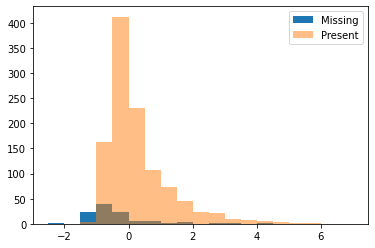

In [7]:
# If we can find a nonlinear transformation that separates missing/present coodrinates quite well - we will definitelly 
# succeed. For now, the best one I found is to bring the normalized pixel values to the power of 3 and then take the mean 
# of the cropped pill (see below). Setting a threshold to around 0.5 gave us around 70 % of accuracy
plt.hist(miss_all, np.arange(-2.5, 7.5, 0.5), label='Missing')
plt.hist(pres_all, np.arange(-2.5, 7.5, 0.5), label='Present', alpha=0.5)
plt.legend()
plt.show()

### Compare our predictions with the ground truth

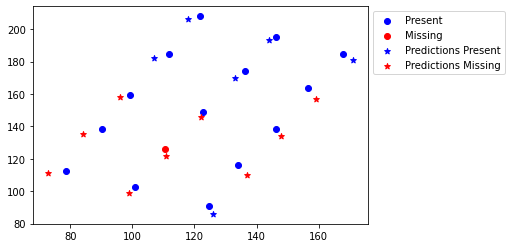

In [8]:
# Ground truth
plt.scatter(np.array(d['coordinates']['present'])[:, 0], np.array(d['coordinates']['present'])[:, 1], color='b',
            label='Present')
plt.scatter(np.array(d['coordinates']['missing'])[:, 0], np.array(d['coordinates']['missing'])[:, 1], color='r',
            label='Missing')
# Predicitons
plt.scatter(np.array(pred_coorp)[:, 0], np.array(pred_coorp)[:, 1], marker='*', color='b', label='Predictions Present')
plt.scatter(np.array(pred_coorm)[:, 0], np.array(pred_coorm)[:, 1], marker='*', color='r', label='Predictions Missing')
plt.legend(bbox_to_anchor=(1, 1))